In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [328]:

root_data_dir = "."

POSITIONS = ['I', 'II', 'III', 'IV', 'V', 'VI']

bussigny_lausanne = pd.ExcelFile(
    os.path.join(
        root_data_dir, "data.xlsx"
    )
)

In [329]:
sheet_names = bussigny_lausanne.sheet_names
sheet_names

['points',
 'players',
 'lineup_set1',
 'lineup_set2',
 'lineup_set3',
 'results',
 'timeouts']

In [330]:
points = pd.read_excel(bussigny_lausanne, "points")
players = pd.read_excel(bussigny_lausanne, "players")
lineup_set1 = pd.read_excel(bussigny_lausanne, "lineup_set1", index_col=0)
lineup_set2 = pd.read_excel(bussigny_lausanne, "lineup_set2", index_col=0)
lineup_set3 = pd.read_excel(bussigny_lausanne, "lineup_set3", index_col=0)
results = pd.read_excel(bussigny_lausanne, "results")
timeouts = pd.read_excel(bussigny_lausanne, "timeouts")

In [331]:
players

,birth_date,number,name,surname,position,captain
0,1997-04-16,21,Nat,NaN,A,NaN
1,1998-01-14,13,Awes,NaN,A,NaN
2,2003-07-25,12,Florent,NaN,A,NaN
3,2000-06-26,11,Luciano,NaN,L,NaN
4,2001-12-27,10,David,NaN,O,NaN
5,1998-12-09,9,Côme,NaN,P,NaN
6,1997-07-01,7,Driss,NaN,C,1.0
7,2002-03-07,5,Wesley,NaN,A,NaN
8,1993-02-28,4,Léo,NaN,A,NaN
9,2007-12-25,3,Ben,NaN,A,NaN


In [267]:

numbers_to_players_dict = {
    row['number']:row['name'] for index, row in players[['number', 'name']].iterrows()
}
players_to_number_dict = {
    v:k for k, v in numbers_to_players_dict.items()
}
numbers_to_position_dict = {
    row['number']:row['position'] for index, row in players[['number', 'position']].iterrows()
}
lineups = {
    1:lineup_set1,
    2:lineup_set2,
    3:lineup_set3
}
numbers_to_position_dict

{21: 'A',
 13: 'A',
 12: 'A',
 11: 'L',
 10: 'O',
 9: 'P',
 7: 'C',
 5: 'A',
 4: 'A',
 3: 'A',
 2: 'O',
 1: 'C'}

In [211]:
chosen_set = 1

In [212]:
# ideal_df = pd.DataFrame({
#     "lausanne":[0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 7.0],
#     "bussigny":[0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 5.0, 5.0, 6.0, 6.0]
# })
# # ideal_df
# sns.lineplot(ideal_df)

In [213]:
import pandas as pd
import numpy as np


def create_scores_series(points:pd.DataFrame, chosen_set:int)->pd.DataFrame:
    
    adversary_team_name = points.columns.drop(['lausanne', 'set'])[0]
    
    df = points.query(f'set == {chosen_set}').drop(columns='set').reset_index(drop=True)

    lausanne, bussigny = df['lausanne'], df[adversary_team_name]

    # Initialize the dataframe with the first point
    df = pd.DataFrame({'lausanne': [0.0], adversary_team_name: [0.0]})
    df = pd.DataFrame(columns=['lausanne', adversary_team_name])

    # Fill out the scores based on the serve-loss data
    lausanne_score = 0
    bussigny_score = 0
    point_number = 0

    # Process each point where lausanne loses serve
    for i in range(len(lausanne)):
        # Fill the points before lausanne loses the serve
        if not np.isnan(lausanne[i]):
            while lausanne_score < lausanne[i]:
                df.loc[point_number] = [lausanne_score, bussigny_score]
                lausanne_score += 1
                point_number += 1

        # Fill the points where bussigny loses the serve
        if not np.isnan(bussigny[i]):
            while bussigny_score < bussigny[i]:
                df.loc[point_number] = [lausanne_score, bussigny_score]
                bussigny_score += 1
                point_number += 1

    # Ensure the last point is added
    df.loc[point_number] = [lausanne_score, bussigny_score]

    df.index.name = 'total_points'
    df.reset_index(inplace=True)
    return df

df = create_scores_series(points, chosen_set)
df

,total_points,lausanne,bussigny
0,0,0,0
1,1,0,1
2,2,1,1
3,3,2,1
4,4,3,1
5,5,3,2
6,6,4,2
7,7,4,3
8,8,4,4
9,9,4,5


In [214]:
def initialize_positions(df:pd.DataFrame, lineups:dict[int, pd.DataFrame], chosen_set:int)->pd.DataFrame:
    positions = ['I', 'II', 'III', 'IV', 'V', 'VI']
    for position in positions:
        df[position] = np.nan
    df.loc[0, positions] = lineups[chosen_set].loc['initial'].astype(int)
    df['new_server'] = df['lausanne'].diff().diff().fillna(0).replace({-1:0})
    return df

df = initialize_positions(df, lineups, chosen_set)

In [215]:
def rotate_positions(pos:list)->list:
    pos += [pos.pop(0)]
    return pos

def rotate_all_positions(df:pd.DataFrame)->pd.DataFrame:
    positions = ['I', 'II', 'III', 'IV', 'V', 'VI']

    positions_rotated = df.query('new_server == 1.0')[positions]
    pos = df.loc[0, positions].tolist()

    for idx, _ in positions_rotated.iterrows():
        pos = rotate_positions(pos)
        positions_rotated.loc[idx] = pos

    df.loc[df['new_server'] == 1.0, positions] = positions_rotated
    df = df.ffill()
    return df

df = rotate_all_positions(df)
df

,total_points,lausanne,bussigny,I,II,III,IV,V,VI,new_server
0,0,0,0,1.0,9.0,3.0,7.0,2.0,13.0,0.0
1,1,0,1,1.0,9.0,3.0,7.0,2.0,13.0,0.0
2,2,1,1,9.0,3.0,7.0,2.0,13.0,1.0,1.0
3,3,2,1,9.0,3.0,7.0,2.0,13.0,1.0,0.0
4,4,3,1,9.0,3.0,7.0,2.0,13.0,1.0,0.0
5,5,3,2,9.0,3.0,7.0,2.0,13.0,1.0,0.0
6,6,4,2,3.0,7.0,2.0,13.0,1.0,9.0,1.0
7,7,4,3,3.0,7.0,2.0,13.0,1.0,9.0,0.0
8,8,4,4,3.0,7.0,2.0,13.0,1.0,9.0,0.0
9,9,4,5,3.0,7.0,2.0,13.0,1.0,9.0,0.0


In [216]:
def player_change_positions(df:pd.DataFrame, lineups:pd.DataFrame, chosen_set:pd.DataFrame)->pd.DataFrame:
    positions = ['I', 'II', 'III', 'IV', 'V', 'VI']

    changes = lineups[chosen_set].dropna(axis=1)
    if not changes.empty:
        for position, change in changes.T.iterrows():
            total_points = change['team_points'] + change['other_team_points']
            df.loc[df['total_points'] >= total_points, positions] = df.loc[df['total_points'] >= total_points, positions].replace({change['initial']:change['change']})
    return df
df = player_change_positions(df, lineups, chosen_set)
df

,total_points,lausanne,bussigny,I,II,III,IV,V,VI,new_server
0,0,0,0,1.0,9.0,3.0,7.0,2.0,13.0,0.0
1,1,0,1,1.0,9.0,3.0,7.0,2.0,13.0,0.0
2,2,1,1,9.0,3.0,7.0,2.0,13.0,1.0,1.0
3,3,2,1,9.0,3.0,7.0,2.0,13.0,1.0,0.0
4,4,3,1,9.0,3.0,7.0,2.0,13.0,1.0,0.0
5,5,3,2,9.0,3.0,7.0,2.0,13.0,1.0,0.0
6,6,4,2,3.0,7.0,2.0,13.0,1.0,9.0,1.0
7,7,4,3,3.0,7.0,2.0,13.0,1.0,9.0,0.0
8,8,4,4,3.0,7.0,2.0,13.0,1.0,9.0,0.0
9,9,4,5,3.0,7.0,2.0,13.0,1.0,9.0,0.0


In [42]:
def switch_lib_in_V_VI_I(df:pd.DataFrame, players:pd.DataFrame)->pd.DataFrame:
    liberos = players.loc[players['position'] == 'L']
    if not liberos.empty:
        centrals = players.loc[players['position'] == 'C']
    lib_num = int(liberos['number'].values[0])
    centrals_num = centrals['number'].tolist()
    central_to_lib_dict = {
        central_num:lib_num for central_num in  centrals_num
    }
    df[['V', 'VI']] = df[['V', 'VI']].replace(central_to_lib_dict)
    
    df['point_won'] = df['lausanne'].diff().fillna(0)
    df.loc[df['point_won'] != 1, 'I'] = df.loc[df['point_won'] != 1, 'I'].replace(central_to_lib_dict)
    return df

df = switch_lib_in_V_VI_I(df, players)

In [43]:
def melt_set_data(df:pd.DataFrame, chosen_set:int, id_vars:list[str]=['total_points', 'I', 'II', 'III', 'IV', 'V', 'VI', 'new_server', 'point_won'], var_name:str='team', value_name:str='points')->pd.DataFrame:
    melted_df = pd.melt(df, id_vars=id_vars, var_name=var_name, value_name=value_name)
    melted_df['set'] = chosen_set
    return melted_df

melted_df = melt_set_data(df, chosen_set)

In [44]:
melted_df

,total_points,I,II,III,IV,V,VI,new_server,point_won,team,points,set
0,0,11.0,9.0,3.0,7.0,2.0,13.0,0.0,0.0,lausanne,0,1
1,1,11.0,9.0,3.0,7.0,2.0,13.0,0.0,0.0,lausanne,0,1
2,2,9.0,3.0,7.0,2.0,13.0,11.0,1.0,1.0,lausanne,1,1
3,3,9.0,3.0,7.0,2.0,13.0,11.0,0.0,1.0,lausanne,2,1
4,4,9.0,3.0,7.0,2.0,13.0,11.0,0.0,1.0,lausanne,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69,32,9.0,5.0,7.0,2.0,13.0,11.0,0.0,0.0,bussigny,22,1
70,33,9.0,5.0,7.0,2.0,13.0,11.0,0.0,0.0,bussigny,23,1
71,34,9.0,5.0,7.0,2.0,13.0,11.0,0.0,0.0,bussigny,24,1
72,35,5.0,7.0,2.0,13.0,11.0,9.0,1.0,1.0,bussigny,24,1


array([1, 2, 3])

In [95]:
def create_set_data(chosen_set:int, points:pd.DataFrame, lineups:dict[int, pd.DataFrame], players:pd.DataFrame)->pd.DataFrame:
    df = create_scores_series(points, chosen_set)
    df = initialize_positions(df, lineups, chosen_set)
    df = rotate_all_positions(df)
    df = player_change_positions(df, lineups, chosen_set)
    df = switch_lib_in_V_VI_I(df, players)
    melted_df = melt_set_data(df, chosen_set)
    return melted_df

def create_match_data(points:pd.DataFrame, lineups:dict[int, pd.DataFrame], players:pd.DataFrame)->pd.DataFrame:
    df = None
    for set_num in points['set'].unique():
        if df is None:
            df = create_set_data(set_num, points, lineups, players)
        else:
            df = pd.concat([df, create_set_data(set_num, points, lineups, players)], axis=0)
    return df

set1_data = create_set_data(1, points, lineups, players)
match_data = create_match_data(points, lineups, players)

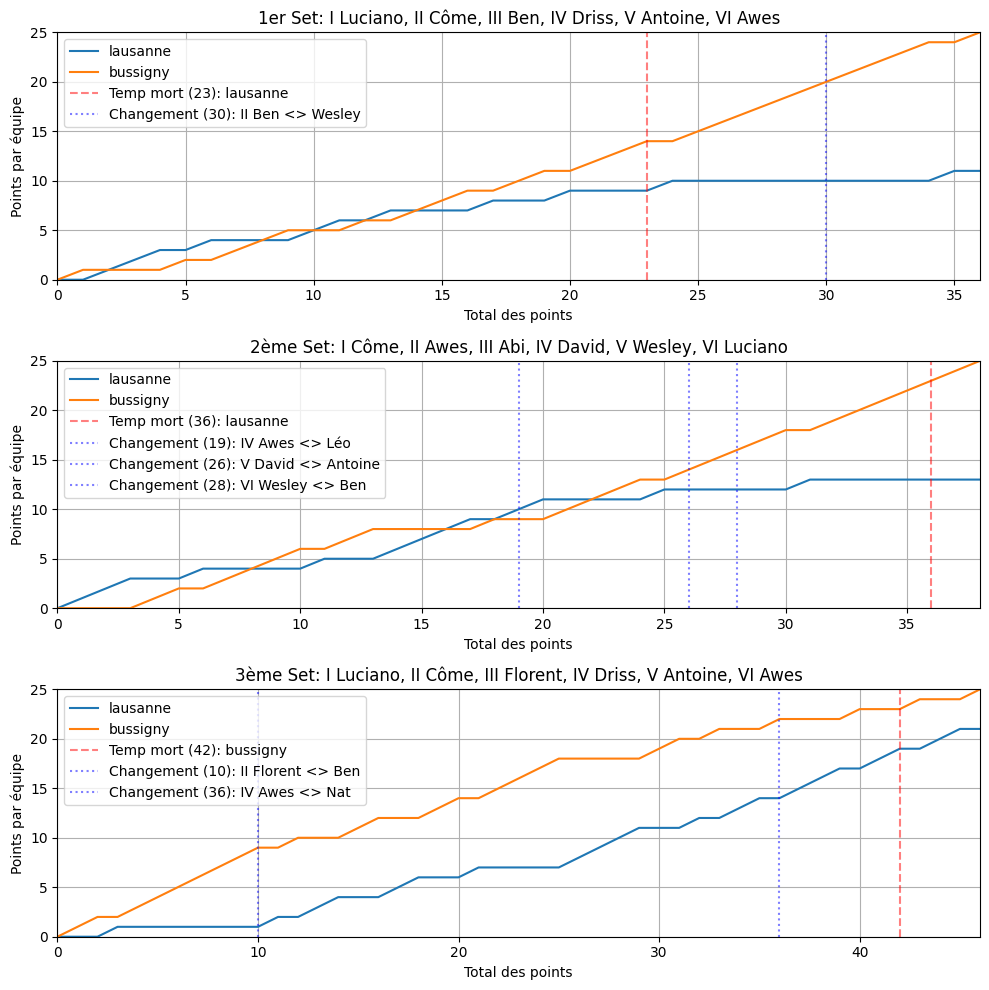

In [403]:
def plot_set_progress(melted_df:pd.DataFrame, chosen_set:int, lineups:dict[int, pd.DataFrame], timeouts:pd.DataFrame, numbers_to_players_dict:dict[int, str], ax):
    set_to_name = {i:f"{i}ème" for i in range(1,6)}
    set_to_name[1] = "1er"
    positions = ['I', 'II', 'III', 'IV', 'V', 'VI']


    ax = sns.lineplot(melted_df.query('set == @chosen_set'), x="total_points", hue="team", y="points", ax=ax)
    ax.set_xlabel("Total des points")
    ax.set_ylabel("Points par équipe")


    # starters = lineups[chosen_set].loc['initial'].astype(int).map(numbers_to_players_dict)
    starters = melted_df.query('set == @chosen_set').iloc[0][positions].map(numbers_to_players_dict)
    starters_string = ''
    for position in positions:
        starters_string += f"{position} {starters[position]}"
        if position != 'VI':
            starters_string += ', '
    starters_string = starters_string.strip()

    ax.set_title(f"{set_to_name[chosen_set]} Set: {starters_string}")
    ax.set_ylim(0, melted_df.query('set == @chosen_set')['points'].max())
    ax.set_xlim(0, melted_df.query('set == @chosen_set')['total_points'].max())


    set_timeouts = timeouts.query('set == @chosen_set')
    if not set_timeouts.empty:
        for _, timeout in set_timeouts.iterrows():
            total_points = timeout['team_points'] + timeout['other_team_points']
            ax.axvline(total_points, label=f"Temp mort ({total_points}): {timeout['team']}", color='r', linestyle='--', alpha=0.5)

    changes = lineups[chosen_set].dropna(axis=1)
    if not changes.empty:
        for position, change in changes.T.iterrows():
            total_points = change['team_points'] + change['other_team_points']
            idx_pos_changed = melted_df.query("(set == @chosen_set) & (team == 'lausanne') & (total_points == @total_points)")[positions].values.squeeze().tolist().index(change['change'])
            
            ax.axvline(total_points, label=f"Changement ({total_points}): {positions[idx_pos_changed]} {numbers_to_players_dict[change['initial']]} <> {numbers_to_players_dict[change['change']]}", color='b', linestyle=':', alpha=0.5)
    ax.legend()
    ax.grid()
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax

fig, axes = plt.subplots(nrows=match_data['set'].max(), ncols=1, figsize=(10, 10), sharex=False)
for i, ax in enumerate(axes.flatten()):
    axes[i] = plot_set_progress(match_data, i+1, lineups, timeouts, numbers_to_players_dict, axes[i])
plt.tight_layout()

In [404]:
match_data

,total_points,I,II,III,IV,V,VI,new_server,point_won,team,points,set
0,0,11.0,9.0,3.0,7.0,2.0,13.0,0.0,0.0,lausanne,0,1
1,1,11.0,9.0,3.0,7.0,2.0,13.0,0.0,0.0,lausanne,0,1
2,2,9.0,3.0,7.0,2.0,13.0,11.0,1.0,1.0,lausanne,1,1
3,3,9.0,3.0,7.0,2.0,13.0,11.0,0.0,1.0,lausanne,2,1
4,4,9.0,3.0,7.0,2.0,13.0,11.0,0.0,1.0,lausanne,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
89,42,2.0,21.0,1.0,9.0,3.0,11.0,0.0,1.0,bussigny,23,3
90,43,2.0,21.0,1.0,9.0,3.0,11.0,0.0,0.0,bussigny,24,3
91,44,21.0,1.0,9.0,3.0,11.0,2.0,1.0,1.0,bussigny,24,3
92,45,21.0,1.0,9.0,3.0,11.0,2.0,0.0,1.0,bussigny,24,3


In [121]:
match_data.columns

Index(['total_points', 'I', 'II', 'III', 'IV', 'V', 'VI', 'new_server',
       'point_won', 'team', 'points', 'set'],
      dtype='object')

In [130]:
positions_data = match_data.query("team == 'lausanne'").melt(var_name='position', value_name='number', id_vars=['total_points', 'new_server', 'point_won', 'points', 'set', 'team']).drop(columns='team')

In [136]:
positions_data['role'] = positions_data['number'].map(numbers_to_position_dict)
positions_data['name'] = positions_data['number'].map(numbers_to_players_dict)
positions_data

,total_points,new_server,point_won,points,set,position,number,role,name
0,0,0.0,0.0,0,1,I,11.0,L,Luciano
1,1,0.0,0.0,0,1,I,11.0,L,Luciano
2,2,1.0,1.0,1,1,I,9.0,P,Côme
3,3,0.0,1.0,2,1,I,9.0,P,Côme
4,4,0.0,1.0,3,1,I,9.0,P,Côme
...,...,...,...,...,...,...,...,...,...
733,42,0.0,1.0,19,3,VI,11.0,L,Luciano
734,43,0.0,0.0,19,3,VI,11.0,L,Luciano
735,44,1.0,1.0,20,3,VI,2.0,O,Antoine
736,45,0.0,1.0,21,3,VI,2.0,O,Antoine


In [141]:
positions_data['name'].value_counts().index

Index(['Côme', 'Luciano', 'Antoine', 'Awes', 'Ben', 'Driss', 'Abi', 'Wesley',
       'David', 'Léo', 'Nat', 'Florent'],
      dtype='object', name='name')

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/2726517933.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


<Axes: title={'center': 'Points Joués par Position'}, xlabel='Joueurs', ylabel='Points joués'>

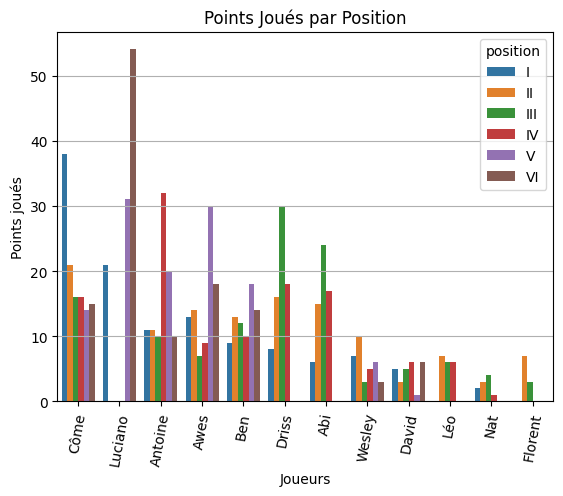

In [397]:
def plot_points_at_each_position(ax, positions_data:pd.DataFrame):
    sns.countplot(positions_data.query('total_points - points  != 25'), hue='position', x='name', order=positions_data['name'].value_counts().index, stat='count', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
    ax.set_ylabel("Points joués")
    ax.set_xlabel("Joueurs")
    ax.grid(axis='y', which='both')
    ax.set_title("Points Joués par Position")
    return ax

fig, ax = plt.subplots()
plot_points_at_each_position(ax, positions_data)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1740110336.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


<Axes: title={'center': 'Points Joués par Joueurs'}, xlabel='Joueurs', ylabel='Points joués'>

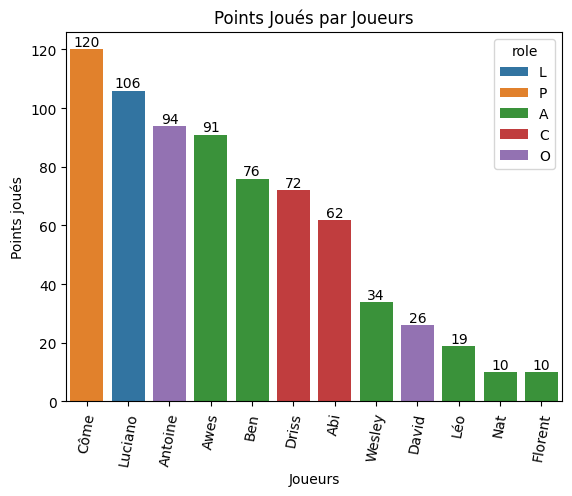

In [387]:
def plot_points_played(ax, positions_data:pd.DataFrame):
    sns.countplot(positions_data.query('total_points - points  != 25'), hue='role', x='name', order=positions_data['name'].value_counts().index, ax=ax)
    ax.set_ylabel("Points joués")
    ax.set_xlabel("Joueurs")
    for label in ax.containers:
        ax.bar_label(label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
    ax.set_title("Points Joués par Joueurs")
    return ax
fig, ax = plt.subplots()
plot_points_played(ax, positions_data)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/2758789998.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


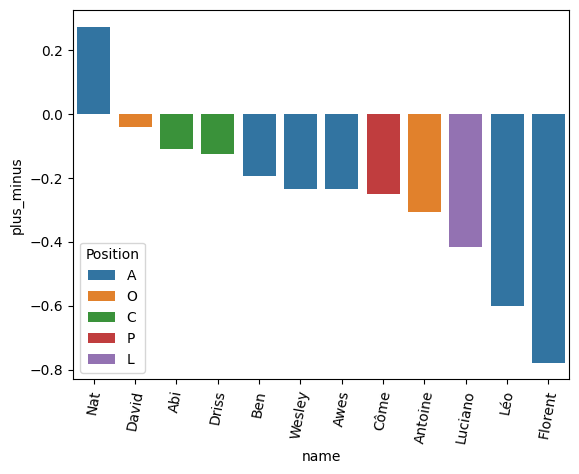

In [388]:
plus_minus_data = pd.DataFrame(positions_data.query('total_points != 0')[['name', 'point_won']].value_counts()).reset_index('point_won')

plus_minus_data = pd.merge(
    plus_minus_data.query('point_won == 0').drop(columns='point_won').rename(columns={'count':'points_lost'}),
    plus_minus_data.query('point_won == 1').drop(columns='point_won').rename(columns={'count':'points_won'}),
    left_index=True, right_index=True
)
plus_minus_data['plus_minus'] = (plus_minus_data['points_won'] - plus_minus_data['points_lost']) / (plus_minus_data['points_lost'] + plus_minus_data['points_won'])
plus_minus_data = plus_minus_data.sort_values(by='plus_minus', ascending=False).reset_index()
plus_minus_data['number'] = plus_minus_data['name'].map(players_to_number_dict)
plus_minus_data['Position'] = plus_minus_data['number'].map(numbers_to_position_dict)

ax = sns.barplot(plus_minus_data, y='plus_minus', x='name', hue='Position')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.show()

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/3825542216.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


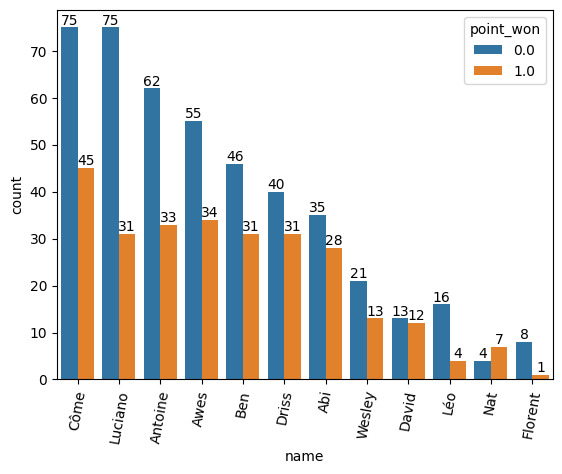

In [389]:
ax = sns.countplot(positions_data.query('total_points != 0'), hue='point_won', x='name', order=positions_data['name'].value_counts().index)
# ax.grid(axis='y', which='both')
for label in ax.containers:
    ax.bar_label(label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.show()

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1151037659.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


<Axes: title={'center': 'Nombre de Passages au Service'}, xlabel='Joueurs', ylabel='Nombre de Passages au Service'>

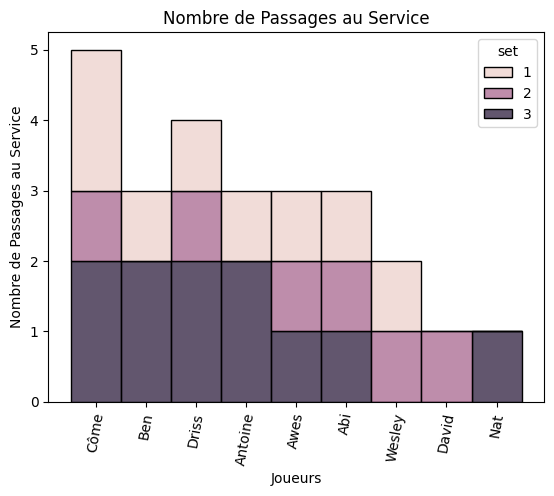

In [390]:
def plot_serve_switches(ax, positions_data:pd.DataFrame):
    sns.histplot(positions_data.query("new_server == 1 & position == 'I'"), hue='set', x='name', multiple='stack', ax=ax)
    # ax.grid(axis='y', which='both')
    # for label in ax.containers:
    #     ax.bar_label(label)
    ax.set_ylabel("Nombre de Passages au Service")
    ax.set_xlabel("Joueurs")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
    ax.set_title("Nombre de Passages au Service")
    return ax


fig, ax = plt.subplots()
plot_serve_switches(ax, positions_data)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1043429839.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


<Axes: title={'center': 'Nombre de Service fais'}, xlabel='Joueurs', ylabel='Nombre de Service fais'>

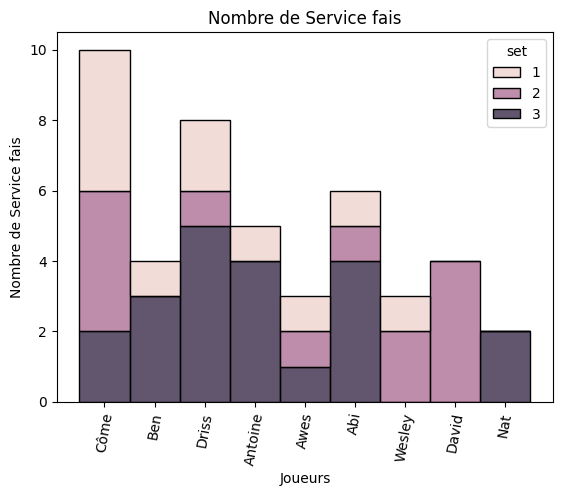

In [391]:
def plot_serve_instances(ax, positions_data:pd.DataFrame):
    sns.histplot(positions_data.query("position == 'I' & point_won == 1"), hue='set', x='name', multiple='stack', ax=ax)
    # ax.grid(axis='y', which='both')
    # for label in ax.containers:
    #     ax.bar_label(label)
    ax.set_ylabel("Nombre de Service fais")
    ax.set_xlabel("Joueurs")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
    ax.set_title("Nombre de Service fais")
    return ax
fig, ax = plt.subplots()
plot_serve_instances(ax, positions_data)

In [392]:
results['duration']

0    00:17:00
1    00:19:00
2    00:22:00
3    00:17:00
4    00:19:00
5    00:22:00
Name: duration, dtype: object

In [393]:
from datetime import time


<Axes: title={'center': 'Durée de chaque Set'}, xlabel='set', ylabel='Durée (min)'>

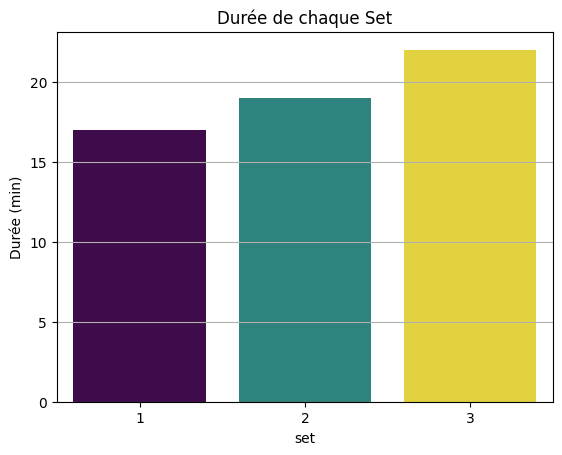

In [408]:
from datetime import time
def plot_set_durations(ax, results:pd.DataFrame):
    results['duration_in_mins'] = results['duration'].map(lambda d : time.fromisoformat(str(d)).minute)
    sns.barplot(results, x='set', y='duration_in_mins', hue='set', legend=None, ax=ax, palette='viridis')
    ax.grid(axis='y')
    ax.set_ylabel("Durée (min)")
    ax.set_title("Durée de chaque Set")
    return ax
fig, ax = plt.subplots()
plot_set_durations(ax, results)

In [409]:
results

,set,team,timeouts,changes,points,start,end,duration,duration_in_mins
0,1,lausanne,1,1,11,20:45:00,21:02:00,00:17:00,17
1,2,lausanne,1,3,13,21:05:00,21:24:00,00:19:00,19
2,3,lausanne,0,2,21,21:27:00,21:49:00,00:22:00,22
3,1,bussigny,0,0,25,20:45:00,21:02:00,00:17:00,17
4,2,bussigny,0,2,25,21:05:00,21:24:00,00:19:00,19
5,3,bussigny,1,2,25,21:27:00,21:49:00,00:22:00,22


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1740110336.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/2726517933.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1151037659.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_12967/1043429839.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

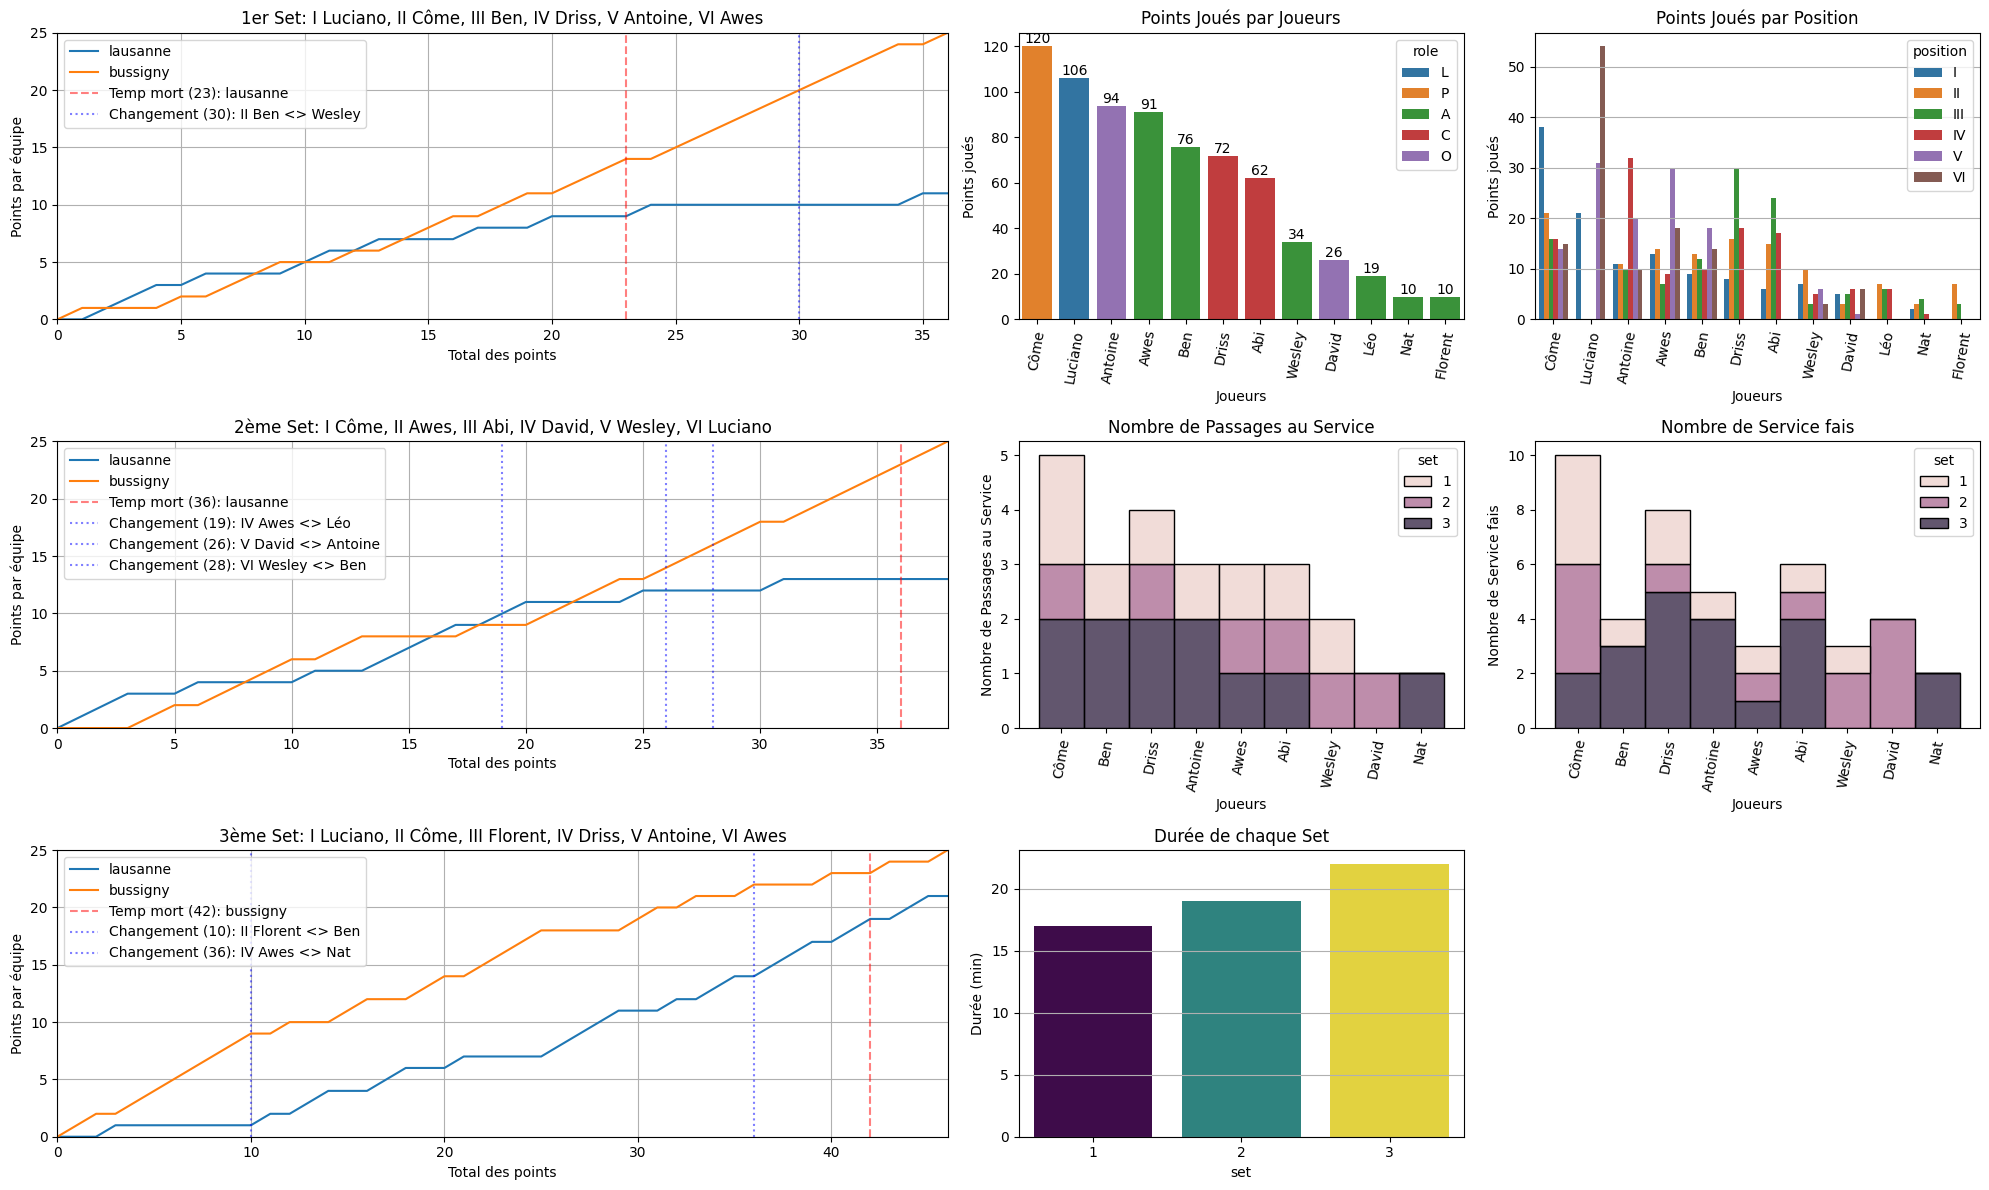

In [411]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,12), width_ratios=[0.4, 0.2, 0.2])
plot_set_progress(match_data, 1, lineups, timeouts, numbers_to_players_dict, axes[0, 0])
plot_set_progress(match_data, 2, lineups, timeouts, numbers_to_players_dict, axes[1, 0])
plot_set_progress(match_data, 3, lineups, timeouts, numbers_to_players_dict, axes[2, 0])
plot_points_played(axes[0, 1], positions_data)
plot_points_at_each_position(axes[0, 2], positions_data)
plot_serve_switches(axes[1, 1], positions_data)
plot_serve_instances(axes[1, 2], positions_data)
plot_set_durations(axes[2, 1], results)
axes[2, 2].set_visible(False)
plt.tight_layout()
plt.savefig('Résumé_match_1_contre_Bussigny.png', dpi=400)